In [2]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.7 MB/s e

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


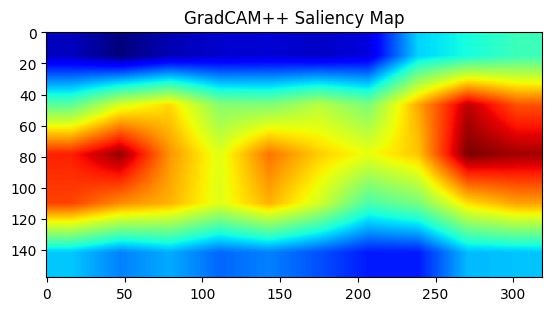

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted 4 objects.


In [65]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models.detection as detection
import torch.nn.functional as F
import cv2
import numpy as np
from sklearn.svm import SVC
from torchvision.models import resnet50
from torchvision.models.detection import maskrcnn_resnet50_fpn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Load your input image
img_path = "/content/dog.jpeg"
image = cv2.imread(img_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = T.Compose([T.ToTensor()])
input_tensor = transform(rgb_image).unsqueeze(0)

# 2. Load Feature Extractor (ResNet)
feature_extractor = resnet50(pretrained=True).eval()

# 3. Apply GradCAM++
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# Target layer for ResNet50
target_layer = feature_extractor.layer4[-1]

# Initialize GradCAM++
cam = GradCAMPlusPlus(model=feature_extractor, target_layers=[target_layer])

# Run GradCAM++ on the image
grayscale_cam = cam(input_tensor=input_tensor)[0, :]
grayscale_cam = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))

# Visualize
plt.imshow(grayscale_cam, cmap='jet')
plt.title("GradCAM++ Saliency Map")
plt.show()


# 4. Load Mask-RCNN for object detection
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True).eval()

with torch.no_grad():
    detections = mask_rcnn(input_tensor)[0]

# 5. Extract detected objects
boxes = detections['boxes']
scores = detections['scores']
threshold = 0.8
keep = scores > threshold
boxes = boxes[keep]

cropped_objects = []

for box in boxes:
    x1, y1, x2, y2 = box.int()
    obj = rgb_image[y1:y2, x1:x2]
    obj = cv2.resize(obj, (64, 64))  # resize for classifier
    cropped_objects.append(obj)

print(f"Extracted {len(cropped_objects)} objects.")

# 6. Prepare dataset for ML Classifier (SVM)
X = [obj.flatten() for obj in cropped_objects]  # Flatten image
y = np.random.randint(0, 2, size=len(X))         # Fake labels (0/1) for example

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 7. Train a simple classifier
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [47]:
boxes

tensor([[222.2419,  20.8095, 313.6255, 141.4221],
        [154.4989,  44.1333, 232.7824, 137.9319],
        [  3.3823,  40.6297, 113.8842, 144.7843],
        [ 84.1507,  42.9017, 164.8329, 133.8547]])

In [66]:
print(type(grayscale_cam), grayscale_cam.dtype)
print(type(boxes))
print(type(mask_rcnn), mask_rcnn.dtype)


<class 'numpy.ndarray'> float32
<class 'torch.Tensor'>


AttributeError: 'MaskRCNN' object has no attribute 'dtype'

In [67]:
import cv2
import numpy as np

height, width = grayscale_cam.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)

boxes = boxes.cpu().numpy()  # If still tensor

for box in boxes:
    xmin, ymin, xmax, ymax = box
    color = (255, 0, 0)  # Red
    cv2.rectangle(blank_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)


In [49]:
import numpy as np
import torch

# Assuming 'mask_rcnn_model' is your loaded model
mask_rcnn.eval()

# Assuming 'rgb_image' is your input image
input_tensor = transform(rgb_image)  # Add proper preprocessing

# Perform inference
with torch.no_grad():
    output = mask_rcnn([input_tensor])[0]  # Get prediction

# Get the masks for all detected objects
masks = output['masks']  # Shape: [num_detections, 1, H, W]

# Iterate over all detected masks
all_masks_rgb = []
for i in range(masks.shape[0]):
    mask = masks[i, 0].cpu().numpy()  # Extract the i-th mask
    mask_rgb = np.stack([mask] * 3, axis=-1)  # Convert to 3-channel for plotting
    mask_rgb = (mask_rgb * 255).astype(np.uint8)  # Convert to 0-255 range
    all_masks_rgb.append(mask_rgb)

# 'all_masks_rgb' contains all the RGB masks, one for each detection


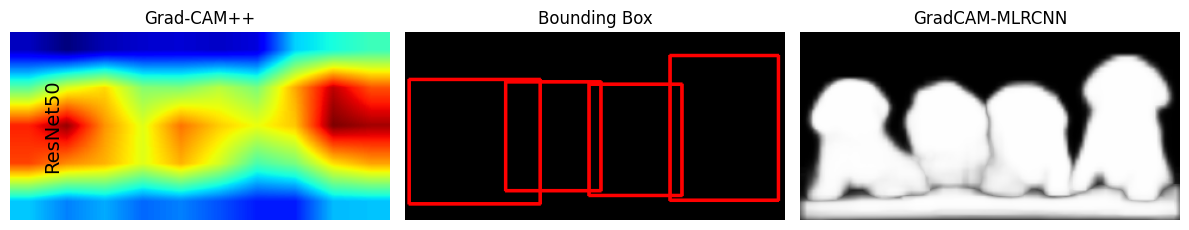

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you have all heatmaps ready as numpy arrays
models = ['ResNet50']
methods = ['Grad-CAM++', 'Bounding Box', 'GradCAM-MLRCNN']

# Your heatmaps dictionary
# Create a blank mask
combined_mask = np.zeros_like(masks[0, 0].cpu().numpy())

# Add all masks together
for i in range(masks.shape[0]):
    mask = masks[i, 0].cpu().numpy()
    combined_mask = np.maximum(combined_mask, mask)  # Take maximum pixelwise

# Normalize if needed
combined_mask = (combined_mask * 255).astype(np.uint8)
combined_mask_rgb = np.stack([combined_mask] * 3, axis=-1)

# Now use combined_mask_rgb for plotting
heatmaps = {
    'ResNet50': {
        'Grad-CAM++': grayscale_cam,
        'Bounding Box': blank_image,
        'GradCAM-MLRCNN': combined_mask_rgb,  # <--- Now this!
    }
}


# Create subplots
fig, axes = plt.subplots(1, len(methods), figsize=(12, 4))  # 1 row only!

for col_idx, method in enumerate(methods):
    ax = axes[col_idx]  # Only index by column
    img = heatmaps['ResNet50'][method]  # Access the heatmap

    ax.imshow(img, cmap='jet')
    ax.axis('off')
    ax.set_title(method, fontsize=12)

# Add a global ylabel for the model (ResNet50)
fig.text(0.04, 0.5, 'ResNet50', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()


In [71]:
import cv2
import numpy as np
gradcam_background = cv2.cvtColor((grayscale_cam * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

height, width = grayscale_cam.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)

 # If still tensor

for box in boxes:
    xmin, ymin, xmax, ymax = box
    color = (255, 0, 0)  # Red
    cv2.rectangle(blank_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)


In [78]:
heatmap = cv2.applyColorMap((grayscale_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB
combined_mask = np.zeros_like(masks[0, 0].cpu().numpy())

for i in range(masks.shape[0]):
    mask = masks[i, 0].cpu().numpy()
    combined_mask = np.maximum(combined_mask, mask)

combined_mask = (combined_mask * 255).astype(np.uint8)
combined_mask_rgb = np.stack([combined_mask] * 3, axis=-1)
combined_mask_rgb = cv2.resize(combined_mask_rgb, (heatmap.shape[1], heatmap.shape[0]))

alpha = 0.5
mask_overlay = cv2.addWeighted(heatmap, 1 - alpha, combined_mask_rgb, alpha, 0)


In [79]:
heatmaps = {
    'ResNet50': {
        'Grad-CAM++': heatmap,  # Just GradCAM++
        'Bounding Box': bbox_on_heatmap,         # GradCAM++ + boxes
        'GradCAM-MLRCNN': mask_overlay,      # GradCAM++ + masks
    }
}


In [84]:
# Copy the heatmap
bbox_on_heatmap = heatmap.copy()

for box in boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(bbox_on_heatmap, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)  # white boxes


In [86]:
combined_mask = np.zeros_like(masks[0, 0].cpu().numpy())
for i in range(masks.shape[0]):
    mask = masks[i, 0].cpu().numpy()
    combined_mask = np.maximum(combined_mask, mask)

combined_mask = (combined_mask * 255).astype(np.uint8)
combined_mask_rgb = np.stack([combined_mask] * 3, axis=-1)
combined_mask_rgb = cv2.resize(combined_mask_rgb, (heatmap.shape[1], heatmap.shape[0]))

alpha = 0.5  # Blending factor
mask_on_heatmap = cv2.addWeighted(heatmap, 1 - alpha, combined_mask_rgb, alpha, 0)


In [87]:
heatmaps = {
    'ResNet50': {
        'Grad-CAM++': heatmap,  # Just GradCAM++
        'Bounding Box': bbox_on_heatmap,         # GradCAM++ + boxes
        'GradCAM-MLRCNN': mask_overlay,      # GradCAM++ + masks
    }
}


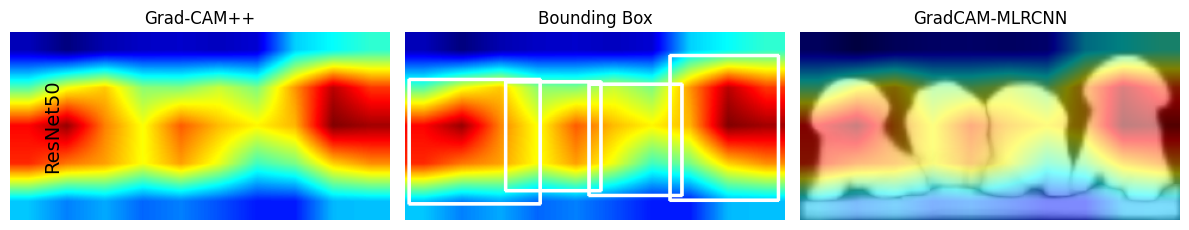

In [88]:
# Create subplots
# Convert grayscale cam to heatmap (color)
heatmap = cv2.applyColorMap((grayscale_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB

fig, axes = plt.subplots(1, len(methods), figsize=(12, 4))  # 1 row only!

for col_idx, method in enumerate(methods):
    ax = axes[col_idx]  # Only index by column
    img = heatmaps['ResNet50'][method]  # Access the heatmap

    ax.imshow(img, cmap='jet')
    ax.axis('off')
    ax.set_title(method, fontsize=12)

# Add a global ylabel for the model (ResNet50)
fig.text(0.04, 0.5, 'ResNet50', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()